In [1]:
import numpy as np
import random
from shapely.geometry import Point, MultiPoint
from scipy.optimize import differential_evolution as scipy_de
from shapely.ops import nearest_points

import voronoi_utils as vu
import solvers

def is_feasible(n, fixed, polygon, A_min, params, solver="custom"):
    if n == 0:
        _, areas = vu.get_voronoi_cells_and_areas(fixed, polygon)
        ok = min(areas) >= A_min
        print(f"[n=0] {'feasible' if ok else 'not feasible'}")
        if ok:
            vu.plot_voronoi(fixed, [], polygon)
        return ok, []

    minx, miny, maxx, maxy = polygon.bounds
    bounds = [(minx, maxx), (miny, maxy)] * n

    def loss(x_flat):
        pts = [(x_flat[i], x_flat[i+1]) for i in range(0, len(x_flat), 2)]
        for xi, yi in pts:
            if not polygon.contains(Point(xi, yi)):
                return 1e6
        _, areas = vu.get_voronoi_cells_and_areas(fixed + pts, polygon)
        return -min(areas)

    if solver == "custom":
        bx, bf = solvers.differential_evolution_custom(loss, bounds, polygon, A_min, params)
    elif solver == "scipy":
        # Early‐exit callback: stop if the minimum Voronoi cell area ≥ A_min
        def _callback(xk, convergence=None):
            # xk is the current best candidate vector
            # loss(xk) = –(min cell area), so –loss(xk) == min cell area
            if -loss(xk) >= A_min:
                return True  # tells SciPy to terminate early
        res = scipy_de(
            loss, bounds,
            maxiter=params["maxiter"],
            popsize=params["popsize"],
            seed=params.get("seed", None),
            updating="deferred",
            callback=_callback
        )
        bx, bf = res.x, res.fun

    elif solver == "qpso":
        bx, bf = solvers.qpso_solver(loss, bounds, polygon, A_min, params)
    elif solver == "qpso2":
        bx, bf = solvers.qpso_pairwise_solver(loss, bounds, polygon, A_min, params)
    elif solver == "ga":
        bx, bf = solvers.ga_solver(loss, bounds, polygon, A_min, params)
    elif solver == "spsa":
        bx, bf = solvers.spsa_solver(loss, bounds, polygon, A_min, params)
    else:
        raise ValueError("Unknown solver")

    best_min = -bf
    ok = best_min >= A_min
    print(f"[n={n}] {'feasible' if ok else 'not feasible'} with min_cell_area = {best_min:.4f}")
    if ok:
        added = [(bx[i], bx[i+1]) for i in range(0, len(bx), 2)]
        vu.plot_voronoi(fixed, added, polygon)
        return True, added
    return False, []

def find_max_additional(fixed, polygon, A_min, params, solver="custom"):
    print(f"Minimum area threshold (A_min): {A_min:.4f}")
    ok, _ = is_feasible(0, fixed, polygon, A_min, params, solver)
    if not ok:
        return 0, []

    low, n = 0, 1
    best_added = []
    while True:
        ok, added = is_feasible(n, fixed, polygon, A_min, params, solver)
        if not ok:
            break
        low, best_added = n, added
        n *= 2

    print(f"Starting binary search between n={low} (feasible) and n={n} (infeasible)")
    lo, hi = low, n
    while lo < hi - 1:
        mid = (lo + hi) // 2
        ok, added = is_feasible(mid, fixed, polygon, A_min, params, solver)
        if ok:
            lo, best_added = mid, added
        else:
            hi = mid

    print(f"Result → Max extra points: {lo}")
    return lo, best_added


# seed
 = 3 we have 8 achivealbe
 
 = 30 we have 9

 = 6 we have 8
 
 = 8 we have 9

In [20]:
s = 8
random.seed(s)
np.random.seed(s)

pts = np.random.rand(30, 2)
polygon = MultiPoint([tuple(p) for p in pts]).convex_hull

fixed = []
minx, miny, maxx, maxy = polygon.bounds
while len(fixed) < 5:
    x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
    if polygon.contains(Point(x, y)):
        fixed.append((x, y))

A_min = polygon.area / 15


spsa_params   = {"maxiter": 300, "a": 0.1, "c": 0.001,
                    "alpha": 0.5, "gamma": 0.001, "restarts": 30, "seed": None}
custom_params = {"maxiter": 450, "popsize": 300, "F": 0.8, "CR": 0.3, "seed": None}
scipy_params  = {"maxiter": 50, "popsize": 25, "seed": None}
qpso_params   = {"maxiter": 350, "popsize": 50, "alpha": 0.75, "seed": None}
ga_params     = {
    "popsize": 50,
    "ngen": 350,
    "cxpb": 0.6,
    "mutpb": 0.3,
    "sigma": 0.1,
    "indpb": 0.1,
    "seed": None
}

=== SPSA Solver ===
Minimum area threshold (A_min): 0.0542
[n=0] feasible
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.332']


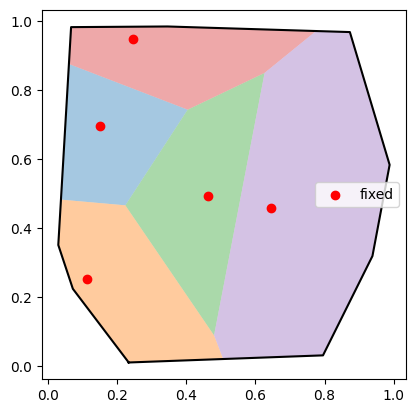

[n=1] feasible with min_cell_area = 0.0543
Voronoi cell areas: ['0.0964', '0.129', '0.134', '0.0543', '0.112', '0.288']


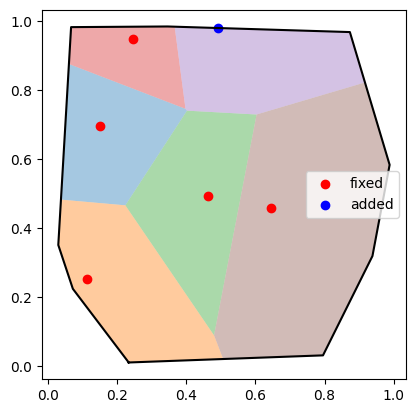

[n=2] feasible with min_cell_area = 0.0551
Voronoi cell areas: ['0.0964', '0.116', '0.0551', '0.129', '0.11', '0.199', '0.109']


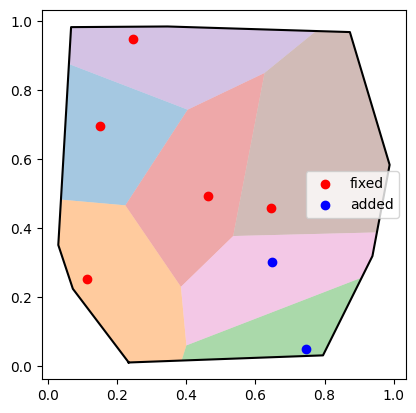

[n=4] feasible with min_cell_area = 0.0555
Voronoi cell areas: ['0.0828', '0.0555', '0.0927', '0.0913', '0.0937', '0.0572', '0.123', '0.113', '0.105']


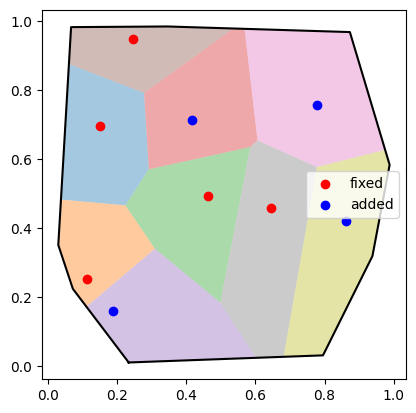

[n=8] feasible with min_cell_area = 0.0544
Voronoi cell areas: ['0.0548', '0.0712', '0.0608', '0.0545', '0.0647', '0.0572', '0.0545', '0.076', '0.0544', '0.0579', '0.0698', '0.0802', '0.0579']


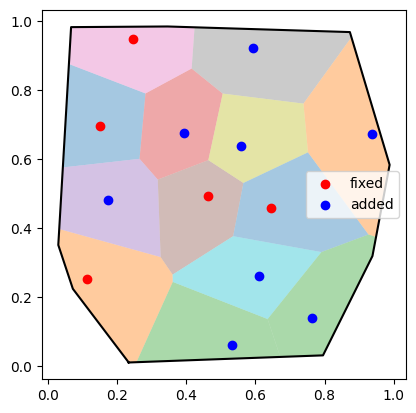

[n=16] not feasible with min_cell_area = 0.0323
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0406
[n=10] not feasible with min_cell_area = 0.0471
[n=9] not feasible with min_cell_area = 0.0516
Result → Max extra points: 8


(8,
 [(np.float64(0.5310140301340234), np.float64(0.06213641093222502)),
  (np.float64(0.60968956587695), np.float64(0.26310027489078663)),
  (np.float64(0.1741189578507421), np.float64(0.48233880587303785)),
  (np.float64(0.5589340270101705), np.float64(0.639494996431263)),
  (np.float64(0.5940722459662046), np.float64(0.9234341169184775)),
  (np.float64(0.39372056683040285), np.float64(0.6751913390777945)),
  (np.float64(0.7635981087452394), np.float64(0.1395677506752493)),
  (np.float64(0.938283429243938), np.float64(0.6745187967578973))])

In [9]:
print("=== SPSA Solver ===")
find_max_additional(fixed, polygon, A_min, spsa_params, solver="spsa")

=== Custom DE ===
Minimum area threshold (A_min): 0.0542
[n=0] feasible
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.332']


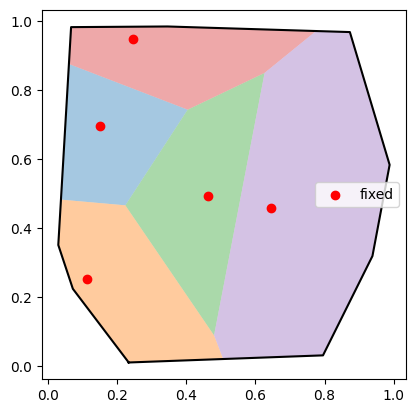

[n=1] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.107', '0.214', '0.121']


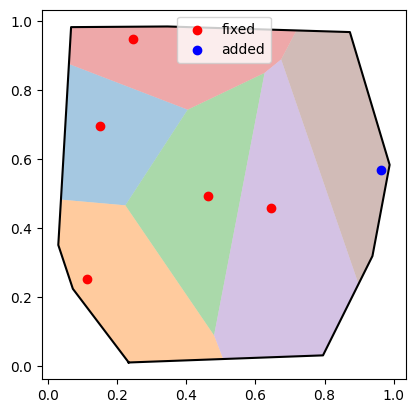

[n=2] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.106', '0.109', '0.104', '0.11', '0.192', '0.0968']


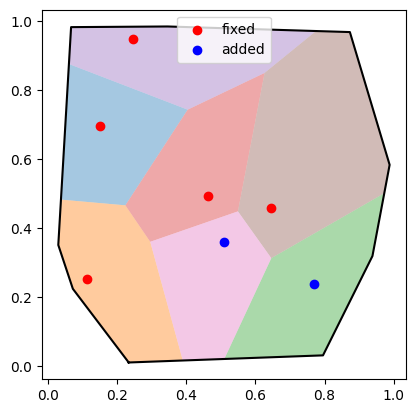

[n=4] feasible with min_cell_area = 0.0703
Voronoi cell areas: ['0.094', '0.0771', '0.106', '0.0715', '0.0743', '0.0703', '0.113', '0.121', '0.0873']


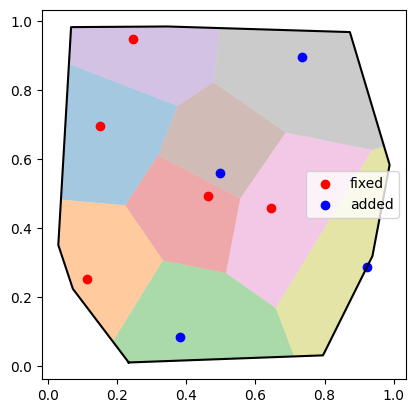

[n=8] not feasible with min_cell_area = 0.0535
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0567
Voronoi cell areas: ['0.0951', '0.0822', '0.0567', '0.0728', '0.0647', '0.0741', '0.0731', '0.0719', '0.0742', '0.0758', '0.0731']


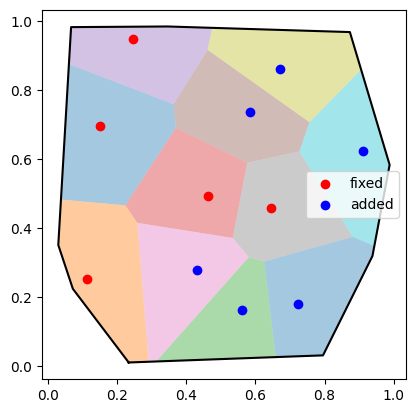

[n=7] feasible with min_cell_area = 0.0557
Voronoi cell areas: ['0.0836', '0.0762', '0.0643', '0.0684', '0.0563', '0.0602', '0.0557', '0.061', '0.0615', '0.0763', '0.0813', '0.0692']


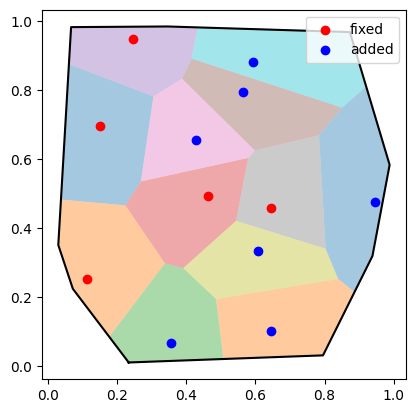

Result → Max extra points: 7


(7,
 [(np.float64(0.5927749722333735), np.float64(0.8818877719202916)),
  (np.float64(0.9468411696444201), np.float64(0.47570437322146447)),
  (np.float64(0.6060930520341932), np.float64(0.33391394361944354)),
  (np.float64(0.5644801265985397), np.float64(0.7951596288186512)),
  (np.float64(0.644255318465328), np.float64(0.10251610867127772)),
  (np.float64(0.427829673891192), np.float64(0.6564878526956418)),
  (np.float64(0.35441901948995885), np.float64(0.06691653855358376))])

In [21]:
print("=== Custom DE ===")
find_max_additional(fixed, polygon, A_min, custom_params, solver="custom")


=== SciPy DE ===
Minimum area threshold (A_min): 0.0542
[n=0] feasible
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.332']


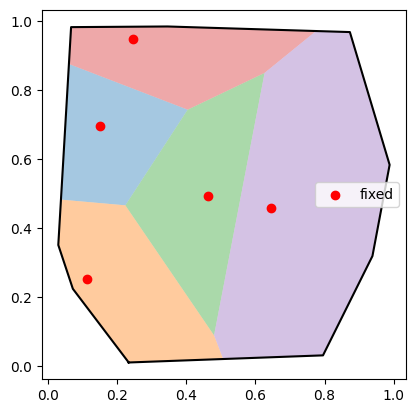

[n=1] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.109', '0.18', '0.153']


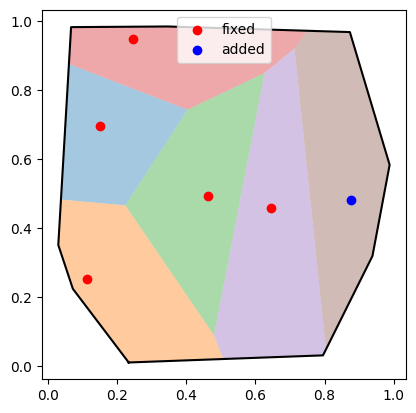

[n=2] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.111', '0.121', '0.0999']


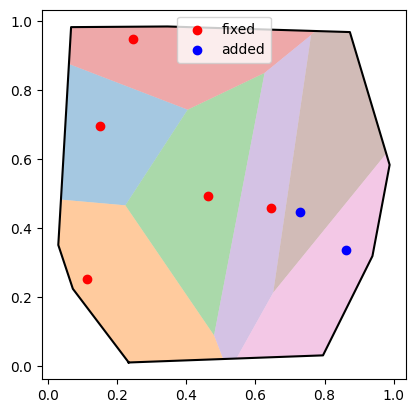

[n=4] feasible with min_cell_area = 0.0778
Voronoi cell areas: ['0.0954', '0.0922', '0.103', '0.0792', '0.0778', '0.0912', '0.0835', '0.105', '0.0865']


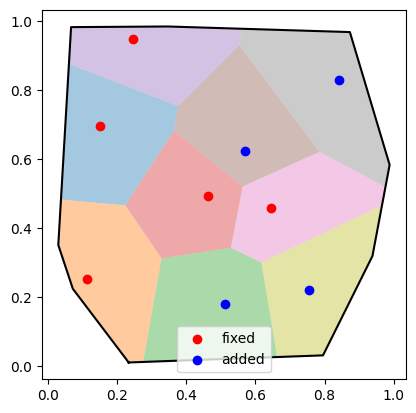

[n=8] not feasible with min_cell_area = 0.0536
Starting binary search between n=4 (feasible) and n=8 (infeasible)
[n=6] feasible with min_cell_area = 0.0677
Voronoi cell areas: ['0.074', '0.0695', '0.0683', '0.0702', '0.0677', '0.0723', '0.0701', '0.0877', '0.078', '0.0883', '0.0677']


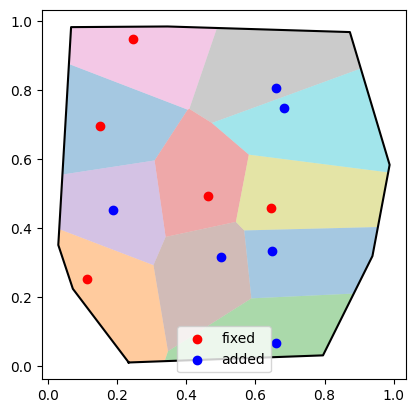

[n=7] feasible with min_cell_area = 0.0665
Voronoi cell areas: ['0.0671', '0.0676', '0.0665', '0.0697', '0.0665', '0.0674', '0.0667', '0.0666', '0.0717', '0.0702', '0.0672', '0.0666']


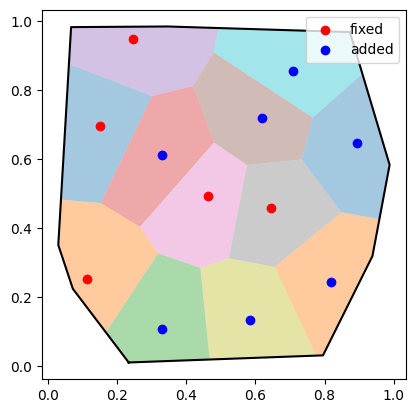

Result → Max extra points: 7


(7,
 [(np.float64(0.6187014203666774), np.float64(0.7200444960282321)),
  (np.float64(0.8933445744078863), np.float64(0.6466119665403298)),
  (np.float64(0.7084886844074316), np.float64(0.8561585055476345)),
  (np.float64(0.8197582085514767), np.float64(0.24366548649199457)),
  (np.float64(0.5840669966696203), np.float64(0.13351433981229024)),
  (np.float64(0.33029462920010616), np.float64(0.10732415682224337)),
  (np.float64(0.32779935722751835), np.float64(0.6123604737074135))])

In [5]:
print("\n=== SciPy DE ===")
find_max_additional(fixed, polygon, A_min, scipy_params, solver="scipy")


=== QPSO (original) ===
Minimum area threshold (A_min): 0.0542
[n=0] feasible
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.332']


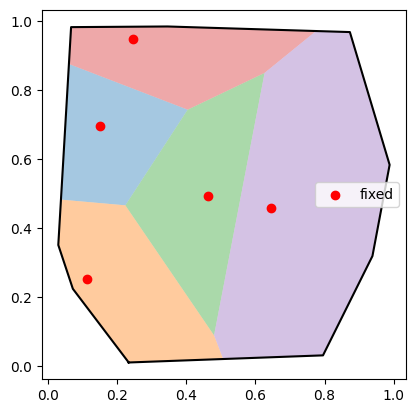

[n=1] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.129', '0.144', '0.0972', '0.135', '0.212']


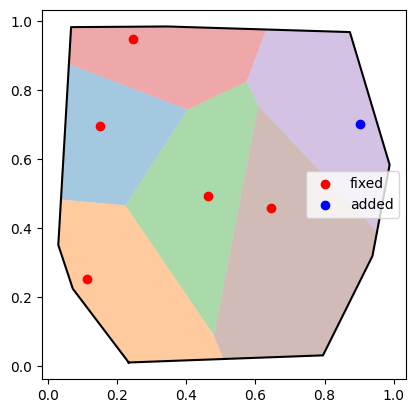

[n=2] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.105', '0.117', '0.132', '0.11', '0.124', '0.13']


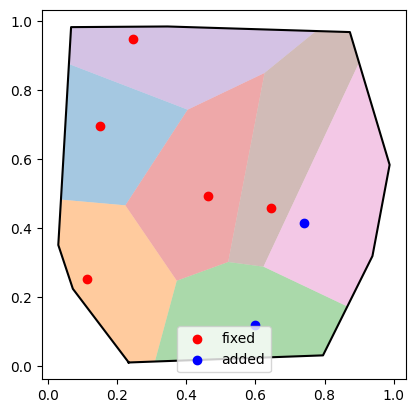

[n=4] feasible with min_cell_area = 0.0621
Voronoi cell areas: ['0.0812', '0.101', '0.112', '0.0759', '0.0621', '0.145', '0.0632', '0.091', '0.0821']


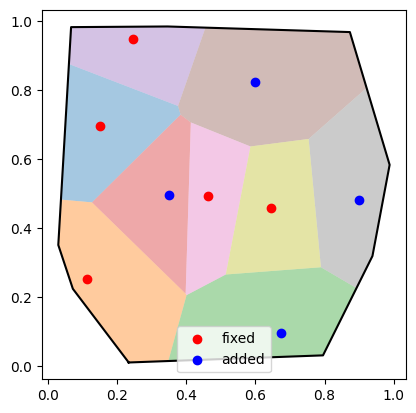

[n=8] feasible with min_cell_area = 0.0543
Voronoi cell areas: ['0.0559', '0.0545', '0.0613', '0.0582', '0.0625', '0.0551', '0.0603', '0.0609', '0.0564', '0.0857', '0.0543', '0.0704', '0.0783']


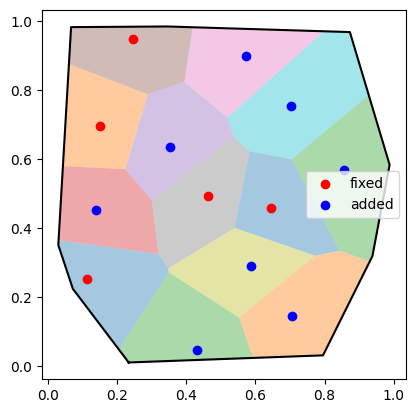

[n=16] not feasible with min_cell_area = 0.0289
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0407
[n=10] not feasible with min_cell_area = 0.0486
[n=9] not feasible with min_cell_area = 0.0539
Result → Max extra points: 8


(8,
 [(np.float64(0.13795648447274997), np.float64(0.4529754062055983)),
  (np.float64(0.5869901043860013), np.float64(0.2919111755754872)),
  (np.float64(0.572078992841485), np.float64(0.8988276396076463)),
  (np.float64(0.42940331206422894), np.float64(0.04761591708265589)),
  (np.float64(0.855806850858447), np.float64(0.5689232383116097)),
  (np.float64(0.35355148697483013), np.float64(0.6359349774691521)),
  (np.float64(0.7015310058011917), np.float64(0.7536576741450723)),
  (np.float64(0.7064162665838111), np.float64(0.1454450610533102))])

In [6]:
print("\n=== QPSO (original) ===")
find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso")


=== QPSO (pairwise) ===
Minimum area threshold (A_min): 0.0542
[n=0] feasible
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.332']


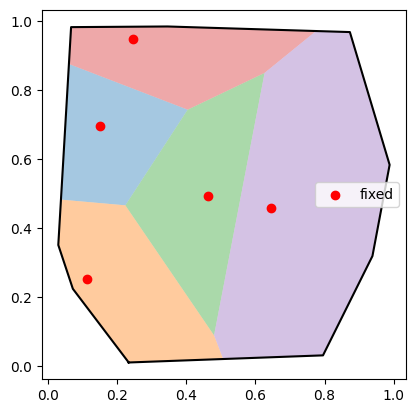

[n=1] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.116', '0.121', '0.139', '0.11', '0.232']


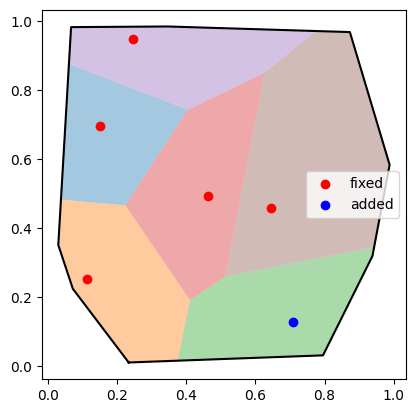

[n=2] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.122', '0.106', '0.142', '0.11', '0.114', '0.124']


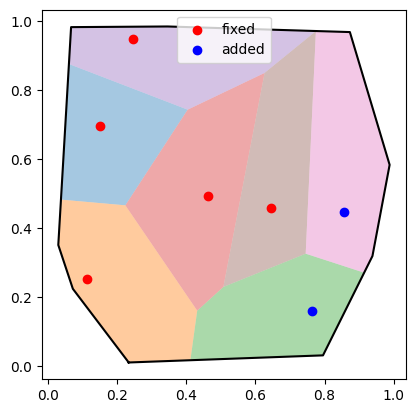

[n=4] feasible with min_cell_area = 0.0698
Voronoi cell areas: ['0.0964', '0.0887', '0.0937', '0.0749', '0.0698', '0.0922', '0.0993', '0.115', '0.0833']


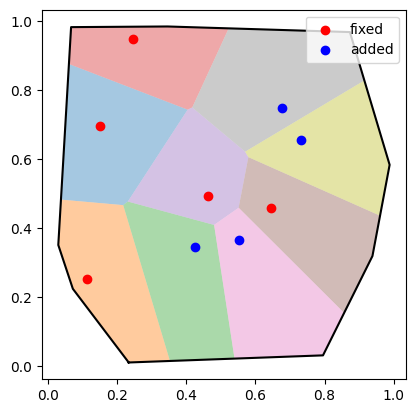

[n=8] feasible with min_cell_area = 0.0543
Voronoi cell areas: ['0.0575', '0.0568', '0.0611', '0.0584', '0.0778', '0.0705', '0.0566', '0.0586', '0.0543', '0.0626', '0.0766', '0.0578', '0.0653']


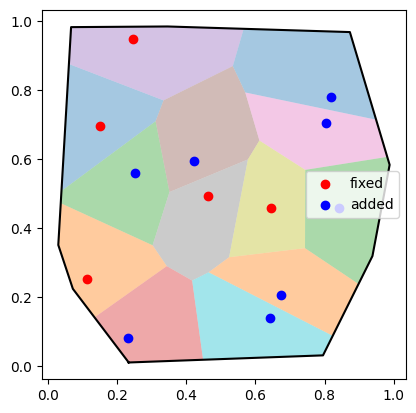

[n=16] not feasible with min_cell_area = 0.0334
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0437
[n=10] not feasible with min_cell_area = 0.0524
[n=9] not feasible with min_cell_area = 0.0529
Result → Max extra points: 8


(8,
 [(np.float64(0.4218892065946215), np.float64(0.593659723718667)),
  (np.float64(0.8035097774939747), np.float64(0.705945313376475)),
  (np.float64(0.6748697933169532), np.float64(0.20685723883926338)),
  (np.float64(0.819117228434777), np.float64(0.780933935316159)),
  (np.float64(0.2300333334040974), np.float64(0.0837023993980778)),
  (np.float64(0.8428248171401461), np.float64(0.4577226737384886)),
  (np.float64(0.6408530369292779), np.float64(0.14044341509646133)),
  (np.float64(0.2515743974583208), np.float64(0.560336641013773))])

In [22]:
print("\n=== QPSO (pairwise) ===")
find_max_additional(fixed, polygon, A_min, qpso_params, solver="qpso2")


=== GA Solver ===
Minimum area threshold (A_min): 0.0542
[n=0] feasible
Voronoi cell areas: ['0.0964', '0.129', '0.147', '0.11', '0.332']


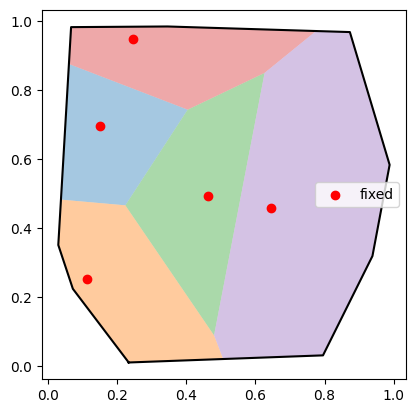

[n=1] feasible with min_cell_area = 0.0964
Voronoi cell areas: ['0.0964', '0.129', '0.142', '0.0986', '0.167', '0.18']


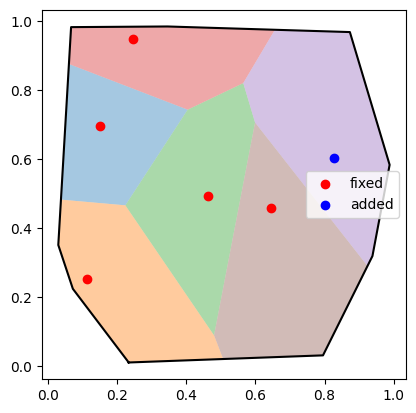

[n=2] feasible with min_cell_area = 0.0958
Voronoi cell areas: ['0.0964', '0.124', '0.116', '0.143', '0.101', '0.137', '0.0958']


/home/kamiar/chevron/Voronoi-for-oil/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/kamiar/chevron/Voronoi-for-oil/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


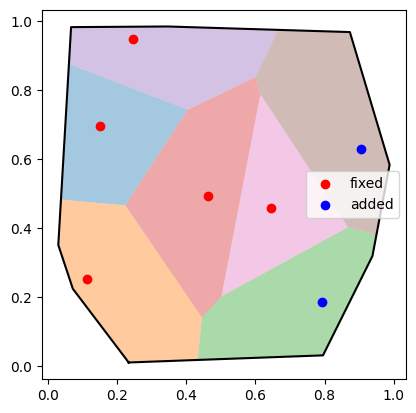

[n=4] feasible with min_cell_area = 0.0621
Voronoi cell areas: ['0.0947', '0.0649', '0.0793', '0.0914', '0.0636', '0.171', '0.0987', '0.0881', '0.0621']


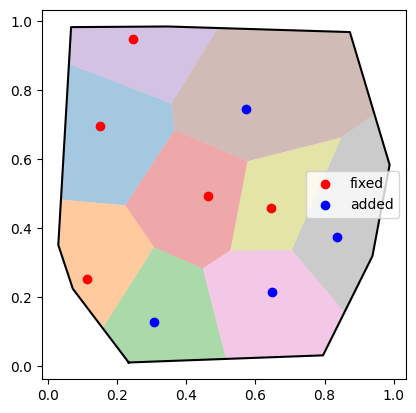

[n=8] feasible with min_cell_area = 0.0545
Voronoi cell areas: ['0.0628', '0.0818', '0.0584', '0.0585', '0.0571', '0.0546', '0.0929', '0.0615', '0.0545', '0.0551', '0.0586', '0.063', '0.055']


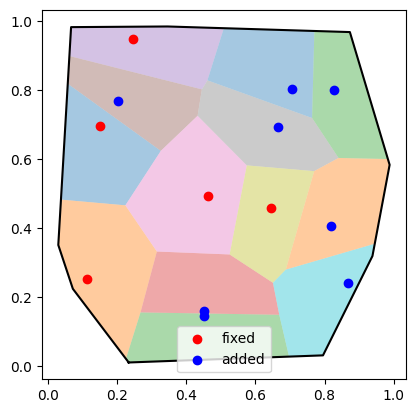

[n=16] not feasible with min_cell_area = 0.0355
Starting binary search between n=8 (feasible) and n=16 (infeasible)
[n=12] not feasible with min_cell_area = 0.0431
[n=10] not feasible with min_cell_area = 0.0518
[n=9] not feasible with min_cell_area = 0.0540
Result → Max extra points: 8


(8,
 [(0.70476358859822, 0.8035676005491633),
  (0.8668837219549881, 0.24306273876008136),
  (0.45025549023635747, 0.16097312995058305),
  (0.6648644882962167, 0.6926703688838057),
  (0.8274946967017158, 0.8003577094567632),
  (0.8188617487286832, 0.40814734888421644),
  (0.44999526116009125, 0.14572117534644202),
  (0.20105554507959067, 0.7682131339841484)])

In [8]:
print("\n=== GA Solver ===")
find_max_additional(fixed, polygon, A_min, ga_params, solver="ga")